Code References :

- https://medium.com/codex/implementing-r-cnn-object-detection-on-voc2012-with-pytorch-b05d3c623afe
- https://pyimagesearch.com/2020/07/13/r-cnn-object-detection-with-keras-tensorflow-and-deep-learning/
- https://sieunpark77.medium.com/how-to-process-voc2012-dataset-and-implement-iou-map-for-object-detection-8ff76891a2ad
- https://learnopencv.com/non-maximum-suppression-theory-and-implementation-in-pytorch/
- https://github.com/FrancescoSaverioZuppichini/non-max-suppression-in-pytorch

In [15]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import os
os.getcwd()

'/content'

In [17]:
!pip install efficientnet_pytorch #using efficientnet as backbone pretrained cnn

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=b50f8c0adc21546f9b7bbe7f676ed98d52a66288d0e8fc3dd8c85eb25eb2071f
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [18]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 9.3 MB/s eta 0:00:00


In [19]:
!pip install wandb #like tensorboard, we visualize logs, accuracy and so on visually

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.7 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=06c4b8a3c79f962d202d2d42fc85a9e6d6ae448b2819f1ed89283504e04d2a4e
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


### **1. Import Packages**

In [20]:
#import the packages
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

from torchmetrics import Accuracy

from efficientnet_pytorch import EfficientNet
#pretrainedmodel = EfficientNet.from_pretrained("efficientnet-b0")

import cv2 #openCV
from google.colab.patches import cv2_imshow  # cv2.imshow for COLAB
#from cv2 import imshow as cv2_imshow # <--- use this for regular use.

from PIL import Image
from skimage import io

import os
import random
import re
import time
import pickle
import shutil
import requests
import urllib.request
import tarfile
from tqdm import tqdm

import xml.etree.ElementTree as ET

import wandb

device = ("cuda:0" if torch.cuda.is_available() else "cpu")

### **2. Set the configurations**

In [21]:
train_hparams_config = {
    "image_size": 224,
    "num_classes": 21, #PASCALVOC N=20+background
    "max_regionproposals": 2000,
    "scale_padding": 16,
    "pretrained_net": "efficientnet-b0", #pretrained efficinet on ImageNetData
    "bbox_reg": True,
}

#SVM classfier config for classification of finetuned model
train_category_classifier_hparams_config = {
    "epochs": 3,
    #after we already finetuned the model and extracted the CNN features,
    #we clasify using per cls linear SVM
    "batch_size": 128,
    "learning_rate": 1e-2,
    "learning_rate_decay": 0.5,
    "l2_reg_lambda": 16-5,
    "log_wandb": True,
    "logging": ["plot"]
}

#PASCAL VOC 2012 Dataset class labels - N=20 + background = 21 classes,
#for visualizations title purposes
voc_2012_classes= [
    "background", "Aeroplane", "Bicycle", "Bird", "Boat", "Bottle", "Bus",
    "Car", "Cat", "Chair", "Cow", "Dining table", "Dog", "Horse", "Motorbike",
    "Person", "Potted plant", "Sheep", "Sofa", "Train", "TV/monitor"
    ]


### **3. Load Dataset - VOC2012 and VOC 2007**

In [22]:
class VOCDataset:
    """
    Load base PASCAL VOC 2007 Dataset with images, labels, bboxannotations
    in base directory path

    This is the data we use for finetuning the pretrained Efficient Net inorder
    to extract CNN features
    """
    def __init__(self):
        """
        Defining Original Pascal Data directories paths and, urls from where the
        data to be extracted
        """
        self.base_train_dir = None
        self.base_test_dir = None
        self.base_train_data_url = None
        self.base_test_data_url = None
        self.preprocess_labels()

    def preprocess_labels(self):
        """
        Preprocess the actual labels to lower case and creates a dictionary
        of preprocessed labels with key as preprocessed label and value as
        its index.

        Also assigns the total number of classes to a variable.

        This is the common initialization step that must be shared among all
        subclasses(i.e child classes)
        """
        self.preprocessed_labels = {}

        #actual class labels from VOC dataset
        self.class_labels = [
            "none", "aeroplane", "Bicycle", "bird", "Boat",
            "Bottle", "Bus", "Car", "Chair", "cow", "Diningtable",
            "Dog", "Horse", "Motorbike", "person", "Pottedplant",
            "sheep", "Sofa", "Train", "TVmonitor"
        ]

        for idx, label in enumerate(self.class_labels):
            #each label as key and idx as value
            self.preprocessed_labels[label.lower()] = idx

        self.num_classes = len(self.class_labels)

    def check_directory(self, filepath):
        """
        Checks whether the directory path containing the specified file path as
        string exists as directory. If it doesn't, it creates the entire
        directory structure to ensure that the file's directory is
        available for use.
        """
        #extracts the directory path from the provided file_path
        directory = os.path.dirname(p=filepath)
        if not os.path.exists(directory):
            #if directory does not exist already, create the directory
            print("Creating Test directory")
            os.makedirs(directory)


    def extract_dataset(self, title="VOC2012", validation_size=5000):
        """
        Download and extract the datasets tar files of train, validation
        and, test(if exists) from the base_*_data_urls tarfiles and copy them
        into the respective base directory paths

        Naming conventions
        - trainval - training, test - val for 2007VOC
        - trainval - training, no test, split val from training data for 2012

        Note:
        - PASCAL VOC2007 has train data as trainval, and
        validation data(we are calling as test here)

        - PASCAL VOC2012 has train data(named trainval) but
        no separate validation data. So we extract 5k images from existing
        train data as validation data.
        """
        print(f"[*] Downloading {title} Train Dataset Tar files")
        #This line saves the extracted tarfile in the current working directory
        #i.e in /content as voctrain.tar
        urllib.request.urlretrieve(url=self.base_train_data_url,
                                   filename="voctrain.tar")
        print(f"[*] Extracting Tar files of {title} Dataset")
        train_tar = tarfile.open(name="voctrain.tar", mode="r:")
        #Extracts all directories+subdirectories from archive into given path
        train_tar.extractall("/content/VOCtrain")
        train_tar.close()
        os.remove("/content/voctrain.tar")
        # print(train_tar.list(verbose=True))

        if self.base_test_data_url is None:
            #Only VOC2007 has test set, VOC2012 has only trainval, but not test
            #We use 5k instances from trainval set as test set for VOC2012
            print(f"[*] Moving Test data from trainval for {title} Dataset")

            #Check if the directory path already exists, if not create path
            test_annotations_path = self.base_test_dir+"/Annotations/"
            test_images_path = self.base_test_dir+"/JPEGImages/"
            self.check_directory(test_annotations_path)
            self.check_directory(test_images_path)

            #get the random samples from train set
            random.seed(42)

            # Get the list of random 5k filepaths from train path for simplicity
            test_img_paths = random.sample(
                population=sorted(
                    os.listdir(
                        self.base_train_dir+"/JPEGImages"
                    )
                ),
                k=validation_size
            )

            for path in test_img_paths:
                #Extract the name of those extracted files
                img_name = os.path.splitext(os.path.basename(path))[0]
                #img_name = path.split('/')[-1].split('.')[0]

                #Move image
                shutil.move(
                    self.base_train_dir+"/JPEGImages/"+img_name+".jpg",
                    self.base_test_dir+"/JPEGImages/"+img_name+".jpg"
                )
                #Move Annotation xml
                shutil.move(
                    self.base_train_dir+"/Annotations/"+img_name+".xml",
                    self.base_test_dir+"/Annotations/"+img_name+".xml"
                )
        else:
            #if validation data exists in archive, then download,extract to path
            print(f"[*] Downloading {title} Test Dataset Tarfiles")

            #saves the extracted tarfiles in current /content as voctrain.tar
            urllib.request.urlretrieve(url=self.base_test_data_url,
                                   filename="voctest.tar")
            print(f"[*] Extracting Tar files of {title} Dataset")
            test_tar = tarfile.open(name="voctest.tar", mode="r:")
            test_tar.extractall("/content/VOCtest")
            test_tar.close()
            os.remove("/content/voctest.tar")

    def parse_xml(self, xml_path):
        """
        Function to parse the XML Annotation files to extract Bounding boxes,
        class labels as a list for each image in the images dataset

        Args:
        xml_path : xml path of an corresponding image

        Returns:
        object_list(type: list) : contains bbbox coords xmin, xmax, ymin, ymax,
        classlabel for each passed image xml path
        """
        object_list =  []

        tree = ET.parse(open(xml_path, "r"))

        root = tree.getroot()
        objects = root.findall("object")
        for _obj in objects:
            class_label = _obj.find("name").text
            bndbox = _obj.find("bndbox").text
            xmin = int(bndbox.find("xmin").text)
            ymin = int(bndbox.find("ymin").text)
            xmax = int(bndbox.find("xmax").text)
            ymax = int(bndbox.find("ymax").text)
            object_list.append(
                {
                    "x1": xmin, "x2": xmax, "y1": ymin, "y2": ymax,
                    "class": self.preprocessed_labels[class_label]
                }
            )
        return object_list

#Sub classes
class VOC2007(VOCDataset):
    def __init__(self):
        self.base_train_dir = "/content/VOCtrain/VOCdevkit/VOC2007"
        self.base_test_dir = "/content/VOCtest/VOCdevkit/VOC2007"
        self.base_train_data_url = "http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar"
        self.base_test_data_url = "http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar"
        self.preprocess_labels()

class VOC2012(VOCDataset):
    def __init__(self):
        self.base_train_dir = "/content/VOCtrain/VOCdevkit/VOC2012" #root is current directory content/
        self.base_test_dir = "/content/VOCtest/VOCdevkit/VOC2012"
        self.base_train_data_url = "http://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar"
        self.base_test_data_url = None
        self.preprocess_labels()

In [23]:
#Initialize and extract the PASCAL VOC 2012 dataset
VOC2012_dataset = VOC2012()
VOC2012_dataset.extract_dataset(title="VOC2012")

[*] Downloading VOC2012 Train Dataset Tar files
[*] Extracting Tar files of VOC2012 Dataset
[*] Moving Test data from trainval for VOC2012 Dataset
Creating Test directory
Creating Test directory


In [24]:
train_datalen = len(os.listdir(VOC2012_dataset.base_train_dir+"/JPEGImages"))
train_annotations_len = len(os.listdir(VOC2012_dataset.base_train_dir+"/Annotations"))

val_datalen = len(os.listdir(VOC2012_dataset.base_test_dir+"/JPEGImages"))
val_annotations_len = len(os.listdir(VOC2012_dataset.base_test_dir+"/Annotations"))

print(f"No. of images and corresponding annotations in training set: {train_datalen}, {train_annotations_len}")
print(f"No. of images and corresponding annorations in validation set: {val_datalen}, {val_annotations_len}")

#Note: here the test set is not actually a test set but a validation set

No. of images and corresponding annotations in training set: 12125, 12125
No. of images and corresponding annorations in validation set: 5000, 5000


### **4. Visualizations of Image and its Ground Truth BBox, and Region Proposals using Selective Search**

2007_000027.jpg


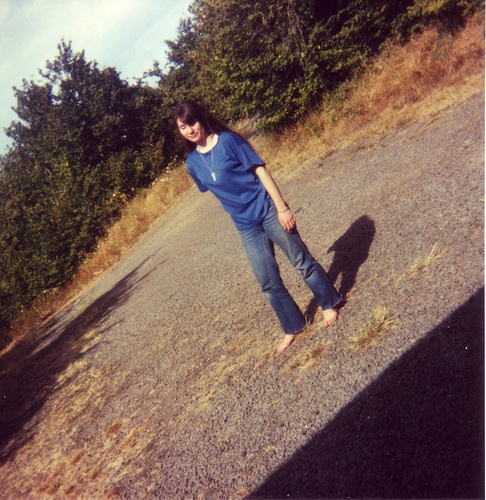

In [25]:
#Visualize image of given index in training data
image_idx = 0
image_file_name = sorted(os.listdir(VOC2012_dataset.base_train_dir+"/JPEGImages"))[image_idx]
print(image_file_name)

#Load the image
image = cv2.imread(VOC2012_dataset.base_train_dir+"/JPEGImages/"+image_file_name)
cv2_imshow(image)

Image Height: 500
Image Width: 486
Image shape: (500, 486, 3)


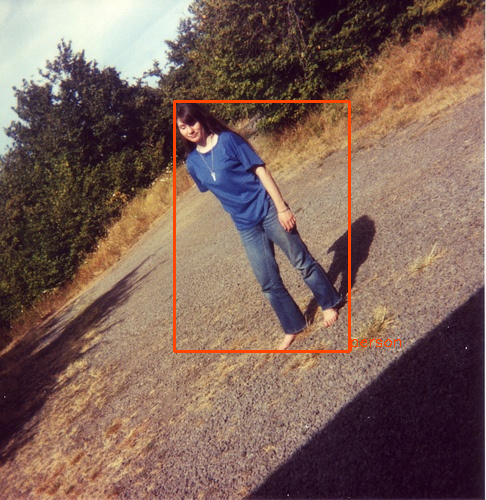

In [26]:
#Plot the Ground Truth BBOx from XML Annotation file of the above image

#Get the XML path for the above image
xml_path = VOC2012_dataset.base_train_dir+"/Annotations/"+image_file_name[:-4]+".xml"

#Parse the XML to get bboxes
tree = ET.parse(xml_path)
root = tree.getroot()
w = root.find("size").find("width").text
h = root.find("size").find("height").text
print(f"Image Height: {h}")
print(f"Image Width: {w}")

#copy the image as we gonna draw the bboxes on the new copied image
new_img = image.copy()
print(f"Image shape: {new_img.shape}")
#Plot the bounding box on the image
objects = root.findall("object")
# print(len(objects)) #only one object for our first image
for _obj in objects:
    bbox = _obj.find("bndbox")
    x_min = int(bbox.find("xmin").text)
    y_min = int(bbox.find("ymin").text)
    x_max = int(bbox.find("xmax").text)
    y_max = int(bbox.find("ymax").text)
    class_label = _obj.find("name").text
    #plot the bbox
    cv2.rectangle(img=new_img, pt1=(x_min, y_min), pt2=(x_max, y_max),
                  color=(0, 69, 255), thickness=2) #color is bgr format in cv2
    #Put text on bbox
    cv2.putText(img=new_img, text=class_label, org=(x_max, y_max-5),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5,
                color=(0, 69, 255), lineType=1)

cv2_imshow(new_img)

Extracted 1263 RP boxes


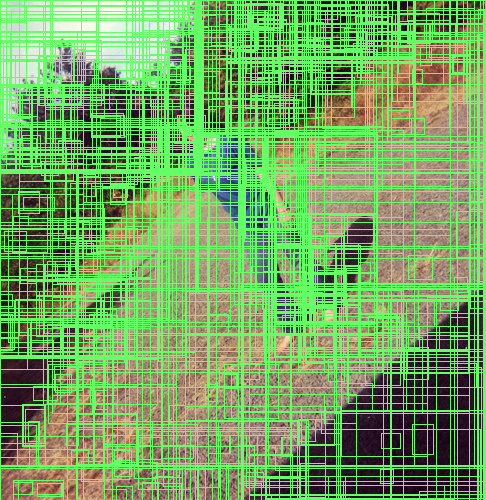

Total time taken to calculate RPs are 0.2928478717803955 seconds


In [27]:
#Plot the candidate region proposals of this above image with the help of Selective Search

#Again create a copy of our original imag to draw RPs on it
new_img_ss = image.copy()

#Selective Search
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(new_img_ss)

#Switch to Fast mode of SS, we also have quuality mode which is accurate but slow
st_time = time.time()
ss.switchToSelectiveSearchFast() #retrieves around 2000 RPs for each image
end_time = time.time()

#process ss to RPs bboxes, each bbox has x, y, w, h realtive to orig image scale
#where x, y is top left corner, not center point
rects = ss.process()

print("Extracted", len(rects), "RP boxes")

#draw the bboxes on image
for idx, rp_bbox in enumerate(rects):
    if idx > 2000: break
    x, y, w, h = rp_bbox
    cv2.rectangle(img=new_img_ss, pt1=(x, y), pt2=(x+w, y+h),
                  color=(100, 255, 100), lineType=1)

cv2_imshow(new_img_ss)
print(f"Total time taken to calculate RPs are {end_time-st_time} seconds")

### **5. Create required Helper functions for RCNN**

- Selective Search
- IOU - Intersection Over Union
- NMS - Non Max Suppression
- Mean Average Precision
- Plotting the Image and bboxes


In [28]:
#Helper functions
def selective_search(img):
    """
    Performs Selective Search on the given image and return all RP bboxes coords

    Args:
    img: Input image of shape (227x227x3)

    Returns:
    rects(type: list): return RP bboxes (x, y, w, h) for each RP in the image
                       Here x, y are coords of top left corner coords of RP.
                       It is this way, cuz we need those coords during inference
                       to map predicted bbox of RPs onto the original image
    """
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    return rects

In [29]:
def compute_IOU(bbox1, bbox2):
    """
    Compute IOU of two bboxes
    Args:
    bbox1: {"x1": x1, "y1": y1, "x2": x2, "y2":y2}
    bbox2: {"x1": x1, "y1": y1, "x2": x2, "y2":y2}
    Note: Here we get Top left corners point and bottom right corner point coords
    for each bbox.

    Returns:
    iou: IOU value of two input bboxes
    """
    iou = 0.0
    (b1_x1, b1_y1, b1_x2, b1_y2) = bbox1.values()
    (b2_x1, b2_y1, b2_x2, b2_y2) = bbox2.values()

    #calculate intersection area top left and bottom right coords #ref yolo coursera
    inter_pt_left_x1 = max(b1_x1, b2_x1)
    inter_pt_left_y1 = max(b1_y1, b2_y1)
    inter_pt_right_x2 = min(b1_x2, b2_x2)
    inter_pt_right_y2 = min(b1_y2, b2_y2)
    intersection_width = inter_pt_right_x2 - inter_pt_left_x1
    intersection_height = inter_pt_right_y2 - inter_pt_left_y1

    #rect area = lxb = hxw
    intersection_area = max(0, intersection_height * intersection_width)

    #union area
    bbox1_area = (b1_x2 - b1_x1) * (b1_y2 - b1_y1)
    bbox2_area = (b2_x2 - b2_x1) * (b2_y2 - b2_y1)
    union_area = bbox1_area + bbox2_area - intersection_area

    iou = intersection_area / union_area

    return iou

In [73]:
def non_max_supression(P, iou_threshold = 0.5, max_boxes=10):
    """
    Applies Non Max Suppression(NMS)using IOU to set of bboxs belongs to a class
    Select the predictions with the maximum confidence and suppress all  other
    predictions having overlap with the selected predictions "greater than"
    a IOU threshold. In other words, we take the maximum and suppress the
    non-maximum ones

    See Ref link above


    Args:
    P(type: list) : list of dicts with each dict contains predictions bboxes and
                    class confidence score, and class label
                    [{"bbox": (x1, y1, x2, y2), "conf": float, "class": int},..]
                    where (x1,y1)and (x2,y2) are the top left and lower right
                    ends of the BBox.
    iou_threshold(type: float) : IOU Overlap threshold to filter out bboxes that
                                 are overlapping with bbox that has maximum conf
                                 score. Keep the only bboxes that has less IOU
                                 overlap with  max conf score bbox
                                IOU of max bbox > iou_threshold

    Returns:
    keep(type: list): A list of filtered prediction BBoxes after applying NMS
                    [{"bbox": (x1, y1, x2, y2), "conf": float, "class": int},..]
    """
    #initialize keep
    keep = []

    #Get the class confidence scores of all bounding boxes
    conf_scores = np.array([i["conf"] for i in P])

    #Sort the scores in ascending order and get the indices using argsort
    #argsort sorts in ascending order and get the sorted indices.we reverse the
    #ascending order to descending using - sign
    order = (-conf_scores).argsort()

    #initialize to_keep with 1s as same shape as number of bboxes we have
    to_keep = np.ones(len(P), dtype=np.bool_) #this acts like a mask

    indices = np.arange(len(P))
    #Looping through each bboxes in P
    for idx in indices:
        if to_keep[idx]:
            #get the indx value from order and get that indxs bbox from P
            #for first iter idx=0, we get sorted idx from order[0]
            #which is idx of bbox of high conf score
            box1 = list(P[order[idx]]["bbox"])
            #converting to dict as IOU function exprects bboxes as dict
            box1 = dict(zip(range(len(box1)), box1))

            #compute IOU of this extracted bbox with all subsequent bboxes in P
            for j in range(idx+1, len(P)):
                if to_keep[j]:
                    box2 = list(P[order[j]]["bbox"])
                    box2 = dict(zip(range(len(box2)), box2))
                    iou = compute_IOU(box1, box2)
                    if iou > iou_threshold:
                        to_keep[j] = False

    #Get the indices where to_keep is True
    filtered_indices = order[to_keep]
    keep.append([P[i] for i in filtered_indices])

    return keep

In [71]:
# @title Optimized IOU and NMS example
#optimized
# import numpy as np

# def non_max_suppression(boxes, scores, iou_threshold=0.5):
#     sorted_indices = np.argsort(-scores)
#     keep = np.ones(len(scores), dtype=np.bool_)

#     for i in range(len(sorted_indices)):
#         if keep[sorted_indices[i]]:
#             bbox = boxes[sorted_indices[i]]
#             iou = box_iou(bbox, boxes[sorted_indices[i+1:]])
#             overlapped = np.where(iou > iou_threshold)
#             keep[overlapped + i + 1] = False

#     return sorted_indices[keep]

# def box_iou(box, boxes):
#     x1 = np.maximum(box[0], boxes[:, 0])
#     y1 = np.maximum(box[1], boxes[:, 1])
#     x2 = np.minimum(box[2], boxes[:, 2])
#     y2 = np.minimum(box[3], boxes[:, 3])

#     intersection = np.maximum(0, x2 - x1) * np.maximum(0, y2 - y1)
#     area1 = (box[2] - box[0]) * (box[3] - box[1])
#     area2 = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
#     union = area1 + area2 - intersection

#     iou = intersection / union
#     return iou

# Usage
# Provide your boxes and scores as NumPy arrays
# boxes = np.array([[], [], ...])  # Your bounding boxes
# scores = np.array([])  # Corresponding scores
# selected_indices = non_max_suppression(boxes, scores)


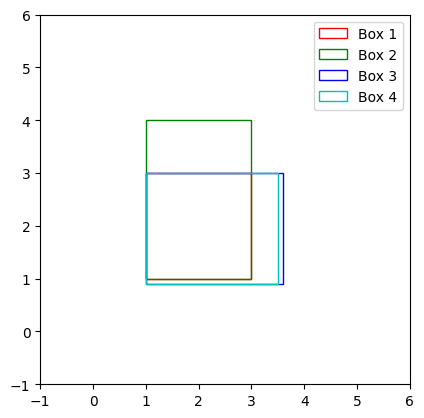

[[{'bbox': (1, 0.9, 3.6, 3), 'conf': 0.98}, {'bbox': (1, 1, 3, 4), 'conf': 0.93}]]
[[{'bbox': (1, 0.9, 3.6, 3), 'conf': 0.98}]]
[[{'bbox': (1, 0.9, 3.6, 3), 'conf': 0.98}]]


In [74]:
#test the above nms function

#overlapping bboxes
P = [
    {"bbox": (1, 1, 3, 3), "conf": 0.95},
     {"bbox": (1, 1, 3, 4), "conf": 0.93},
      {"bbox": (1, 0.9, 3.6, 3), "conf": 0.98},
       {"bbox": (1, 0.9, 3.5, 3), "conf": 0.97}
]

from matplotlib import patches
import matplotlib.pyplot as plt
def plot_iou():
    #skeleton
    # rect1 = patches.Rectangle(
    #     (box1[0], box1[1]), width=box1[2] - box1[0], height=box1[3] - box1[1],
    #     linewidth=1, edgecolor='r', facecolor='none', label='Box 1')
    # ax.add_patch(rect1)

    fig, ax = plt.subplots(1)
    # Draw Box 1
    rect1 = patches.Rectangle((1, 1), 3 - 1, 3 - 1, linewidth=1, edgecolor='r',
                              facecolor='none', label='Box 1')
    ax.add_patch(rect1)
    # Draw Box 2
    rect2 = patches.Rectangle((1, 1), 2, 3, linewidth=1, edgecolor='g',
                              facecolor='none', label='Box 2')
    ax.add_patch(rect2)
    # Draw Box 2
    rect2 = patches.Rectangle((1, 0.9), 2.6, 2.1, linewidth=1, edgecolor='b',
                              facecolor='none', label='Box 3')
    ax.add_patch(rect2)
    # Draw Box 2
    rect2 = patches.Rectangle((1, 0.9), 2.5, 2.1, linewidth=1, edgecolor='c',
                              facecolor='none', label='Box 4')
    ax.add_patch(rect2)

    plt.xlim(-1, 6)
    plt.ylim(-1, 6)
    plt.gca().set_aspect('equal', adjustable='box')

    plt.legend()
    plt.show()
plot_iou()

#test the function nms
keep = non_max_supression(P, iou_threshold=0.7)
print(keep)

keep = non_max_supression(P, iou_threshold=0.5)
print(keep)

keep = non_max_supression(P, iou_threshold=0.3)
print(keep)

#observe how increasing the threshold resulted in getting 2 bboxes green, blue
#as result.
#the iou overlap btwn those are less than threshold 0.7, so got 2 boxes

In [75]:
def plot_results(img, bboxes, color=(0, 69, 255)):
    new_img_ss = img.copy()
    for bbox in bboxes:
        cv2.rectangle(
            img=new_img_ss, pt1=(bbox["x1"], bbox["y1"]),
            pt2=(bbox["x2"], bbox["y2"]),  color=color, thickness=1
        )
        label = bbox["class"]
        confidence_score = str(bbox["conf"])[:5]
        cv2.putText(
            img=new_img_ss,
            text=f"{VOC2012_dataset.class_labels[label]},{confidence_score}",
            color=color, thickness=1, org=(bbox["x1"], bbox["y1"]-5),
            fontScale=0.3, fontFace=cv2.FONT_HERSHEY_SIMPLEX, lineType=1
        )
    return new_img_ss

In [76]:
def mean_average_precision(pred_bboxes, gt_bboxes, iou_threshold = 0.5,
                           num_classes = 21, per_class = False):
    """
    Calculates Mean Average Precision with Precision, Recall AUC
    Calculate Precision and Recall per bbox of a class and plot PR curve and
    calculates AUC to get Average Precision of that class.

    Likewise calculates AP for all classes and then calculates mean of all APs
    to get MAP Mean Average Precision

    Args:
    pred_bboxes: prediction bboxes list of lists where each list in format

    [[{'bbox':{'x1', 'x2', 'y1', 'y2'}, 'class':int, 'conf':float}, ...], ...]

    gt_bboxes: list of lists of Ground truth bboxes per image

         [[{'x1', 'x2', 'y1', 'y2', 'class': int}, more boxes...], ...]

    iou_threshold(type: float): Overlapping IOU threshold with GT bboxes
    num_classes(type:int): 21 classes for PASCAL VOC
    per_class(type: boolean): Return APs of all classes if is it true, not MAP

    Returns:
    average_precisions: if per_class is True
    mean_average_precisions: if per_class is False
    """

    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(1, num_classes): # class '0' is background
        # get the predicted objects bboxes, scores of each class c as list
        detections = []

        for idx, preds in enumerate(pred_bboxes):
            #for each preds, we will have many bboxes for many objects
            for pr in preds:
                if pr["class"] == c:
                    detections.append((pr["conf"], idx, pr["bbox"]))
        detections.sort(reverse=True)

        #True positives
        TP = torch.zeros((len(detections)))
        #False positives
        FP = torch.zeros((len(detections)))

        # make checkbox for checking whether ground truth object was detected
        total_gt_bboxes = 0
        is_detected = []
        for gts in gt_bboxes:
            #creating mask with False
            is_detected.append([False for _ in gts])
            #counting the gt bboxes for objects of each class
            total_gt_bboxes += sum([gt['class']==c for gt in gts])

        if total_gt_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            num_gts = len(gt_bboxes[detection[1]])

            # find most closest g.t box to pred as best_gt_idx
            best_iou = 0
            for idx, gt in enumerate(gt_bboxes[detection[1]]):
                iou = compute_IOU(gt, detection[2])
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx
            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if is_detected[detection[1]][best_gt_idx] == False:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    is_detected[detection[1]][best_gt_idx] = True
                else: # duplicate is FP
                    FP[detection_idx] = 1
            else:
                # if IOU is lower then the detection is a false positive
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)

        # ratio of detected objects!
        recalls = TP_cumsum / (total_gt_bboxes + epsilon)

        # ratio of predictions that are true objects!
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)

        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))

        average_precisions.append(torch.trapz(precisions, recalls))

    if per_class:
        return average_precisions
    else:
        return sum(average_precisions) / len(average_precisions)

### RCNN Data Loaders
    - Create Data for CNN Feature Extraction with Fine Tuning(Data Warping, data augmentations as well)
    - Create Data for SVM Category Classification
    - Create Data for BBox Regression